In [1]:
# %matplotlib inline
# %matplotlib notebook
from dataGen import Gen
from multiscale_vae import vae
from train import slidingWindow, criterion, train, test
from Encoders import LongShort_TCVAE_Encoder
from Decoders import LongShort_TCVAE_Decoder
from vae import VariationalAutoencoder

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.distributions


import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
# all parameters for generating the time series should be configured in this cell
periode = 15 #days
step = 5 # mess interval in minutes
val = 100
n_channels = 3
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":2,   
        "interval":20
        },
    "Trend": {
        "occurances":1,
        "max_slope":0.005,
        "type":"mixed"
        },
    "Seasonality": {
        "occurances":2,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

### Init Model
latent_dims = 15
L = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# v = vae(n_channels, L, latent_dims)
v = VariationalAutoencoder(input_size = n_channels,
                           hidden_size = 10,
                           num_layers = 4,
                           latent_dims= latent_dims,
                           v_encoder = LongShort_TCVAE_Encoder,
                           v_decoder = LongShort_TCVAE_Decoder,
                           L = L,
                           first_kernel = 15)
opt = optim.Adam(v.parameters(), lr = 0.001)

{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [5, 15],
                 'channel': [0, 1],
                 'frequency_per_week': [8.386440053317369, 12.323714985392712],
                 'phaseshift': [40, 164]},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [1],
           'index': ['2023-03-05T02:20:00'],
           'slope': [-1.4929876974096104e-05]}}


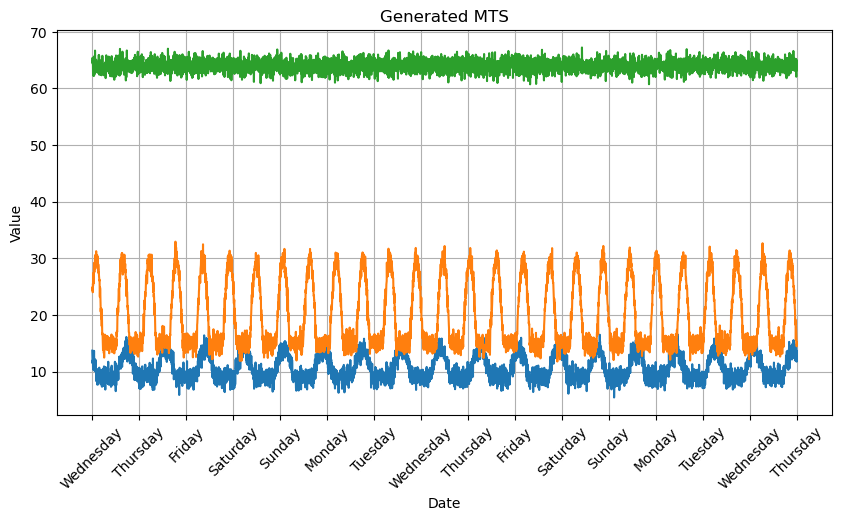

In [3]:
X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()

In [6]:
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

# train_set = slidingWindow(train, 30)
# val_set = slidingWindow(val, 30)
# test_set = slidingWindow(test, 30)

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=10,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=10,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=10,
                        shuffle = False
                        )

In [7]:
print(v)

VariationalAutoencoder(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder(
      (cnn_layers): ModuleList(
        (0): Conv1d(3, 6, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(6, 12, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(12, 18, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Conv1d(18, 24, kernel_size=(2,), stride=(2,))
        (10): LeakyReLU(negative_slope=0.2, inplace=True)
        (11): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Sequenti

In [8]:
for epoch in range(1, 100):
    train(v, train_data, criterion, opt, device, epoch)

Train Epoch: 1 [0/3396 (0%)]	Loss: 4906.896094
Train Epoch: 1 [1000/3396 (29%)]	Loss: 4448.687891
Train Epoch: 1 [2000/3396 (59%)]	Loss: 3517.869922
Train Epoch: 1 [3000/3396 (88%)]	Loss: 2676.710352
====> Epoch: 1 Average loss: 3586.1466
Train Epoch: 2 [0/3396 (0%)]	Loss: 2579.238281
Train Epoch: 2 [1000/3396 (29%)]	Loss: 2117.110742
Train Epoch: 2 [2000/3396 (59%)]	Loss: 1608.714648
Train Epoch: 2 [3000/3396 (88%)]	Loss: 1153.931738
====> Epoch: 2 Average loss: 1717.0517
Train Epoch: 3 [0/3396 (0%)]	Loss: 1019.931934
Train Epoch: 3 [1000/3396 (29%)]	Loss: 753.889209
Train Epoch: 3 [2000/3396 (59%)]	Loss: 487.424414
Train Epoch: 3 [3000/3396 (88%)]	Loss: 280.028809
====> Epoch: 3 Average loss: 573.6519
Train Epoch: 4 [0/3396 (0%)]	Loss: 238.476416
Train Epoch: 4 [1000/3396 (29%)]	Loss: 196.387524
Train Epoch: 4 [2000/3396 (59%)]	Loss: 107.860022
Train Epoch: 4 [3000/3396 (88%)]	Loss: 38.861136
====> Epoch: 4 Average loss: 124.7133
Train Epoch: 5 [0/3396 (0%)]	Loss: 53.343683
Train Epo

Train Epoch: 36 [2000/3396 (59%)]	Loss: 8.389459
Train Epoch: 36 [3000/3396 (88%)]	Loss: 18.613118
====> Epoch: 36 Average loss: 9.7742
Train Epoch: 37 [0/3396 (0%)]	Loss: 7.640494
Train Epoch: 37 [1000/3396 (29%)]	Loss: 7.634572
Train Epoch: 37 [2000/3396 (59%)]	Loss: 7.997572
Train Epoch: 37 [3000/3396 (88%)]	Loss: 15.327766
====> Epoch: 37 Average loss: 9.5683
Train Epoch: 38 [0/3396 (0%)]	Loss: 6.873676
Train Epoch: 38 [1000/3396 (29%)]	Loss: 7.773816
Train Epoch: 38 [2000/3396 (59%)]	Loss: 8.683556
Train Epoch: 38 [3000/3396 (88%)]	Loss: 8.771046
====> Epoch: 38 Average loss: 9.4577
Train Epoch: 39 [0/3396 (0%)]	Loss: 6.328448
Train Epoch: 39 [1000/3396 (29%)]	Loss: 7.139490
Train Epoch: 39 [2000/3396 (59%)]	Loss: 11.009547
Train Epoch: 39 [3000/3396 (88%)]	Loss: 9.569627
====> Epoch: 39 Average loss: 9.5136
Train Epoch: 40 [0/3396 (0%)]	Loss: 6.066590
Train Epoch: 40 [1000/3396 (29%)]	Loss: 7.342660
Train Epoch: 40 [2000/3396 (59%)]	Loss: 9.203342
Train Epoch: 40 [3000/3396 (88%)

Train Epoch: 72 [1000/3396 (29%)]	Loss: 6.992937
Train Epoch: 72 [2000/3396 (59%)]	Loss: 8.610660
Train Epoch: 72 [3000/3396 (88%)]	Loss: 6.019130
====> Epoch: 72 Average loss: 8.2767
Train Epoch: 73 [0/3396 (0%)]	Loss: 5.056324
Train Epoch: 73 [1000/3396 (29%)]	Loss: 7.119664
Train Epoch: 73 [2000/3396 (59%)]	Loss: 7.787530
Train Epoch: 73 [3000/3396 (88%)]	Loss: 10.844209
====> Epoch: 73 Average loss: 8.5866
Train Epoch: 74 [0/3396 (0%)]	Loss: 6.027789
Train Epoch: 74 [1000/3396 (29%)]	Loss: 7.211182
Train Epoch: 74 [2000/3396 (59%)]	Loss: 8.626322
Train Epoch: 74 [3000/3396 (88%)]	Loss: 11.167911
====> Epoch: 74 Average loss: 8.2868
Train Epoch: 75 [0/3396 (0%)]	Loss: 5.607854
Train Epoch: 75 [1000/3396 (29%)]	Loss: 6.801263
Train Epoch: 75 [2000/3396 (59%)]	Loss: 11.102356
Train Epoch: 75 [3000/3396 (88%)]	Loss: 5.515294
====> Epoch: 75 Average loss: 8.3266
Train Epoch: 76 [0/3396 (0%)]	Loss: 6.073610
Train Epoch: 76 [1000/3396 (29%)]	Loss: 7.104796
Train Epoch: 76 [2000/3396 (59%)

In [9]:
def compare(dataset, model):
    model.eval()
    rec = []
    x = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            x_rec, mu, logvar = model(data)
            z = v.reparametrization_trick(mu, logvar)

            x.extend(data[:,:,0].detach().numpy())
            rec.extend(x_rec[:].detach().numpy())
        
    print(mu[-1, :], logvar[-1, :])
    plt.plot(rec, "r--")
    plt.plot(x[:], "b-")
    plt.ylim(0,100)
    plt.grid(True)
    
    return z[-1, :]

tensor([-4.4630e-02, -1.8286e-02,  2.4820e-02, -1.4793e-02, -4.7801e-02,
        -2.7887e-02,  3.1281e-03,  6.7710e-02, -4.7192e-02, -5.6667e-02,
        -6.0106e-02, -3.2134e-02, -2.4136e-02,  1.3744e+00, -5.1241e-02,
         3.5493e-03,  4.1989e-03,  8.6285e-03,  2.1438e-04,  2.4221e-02,
        -2.0848e+00, -1.8134e-03,  4.3736e-04,  6.3140e-03,  7.6271e-04,
        -4.9008e-03,  3.3349e-02,  1.9404e-02, -1.6293e-02,  6.5976e-03]) tensor([-1.9346e-02, -8.5105e-03, -9.9543e-03, -3.8230e-03,  4.2941e-03,
         4.8397e-03, -1.0624e-02, -8.5891e-03, -3.2191e-02,  1.1154e-03,
         4.9577e-02, -2.0254e-04,  3.0830e-02, -4.6806e-01, -1.3422e-02,
         4.1444e-03, -1.4405e-02,  1.8549e-02, -5.7734e-02,  3.8471e-02,
        -1.0959e+00,  2.5118e-02, -7.3990e-02, -6.1767e-03, -5.1364e-03,
         3.4714e-03, -2.0848e-02,  7.4481e-03,  7.4860e-03, -3.1881e-02])


<IPython.core.display.Javascript object>


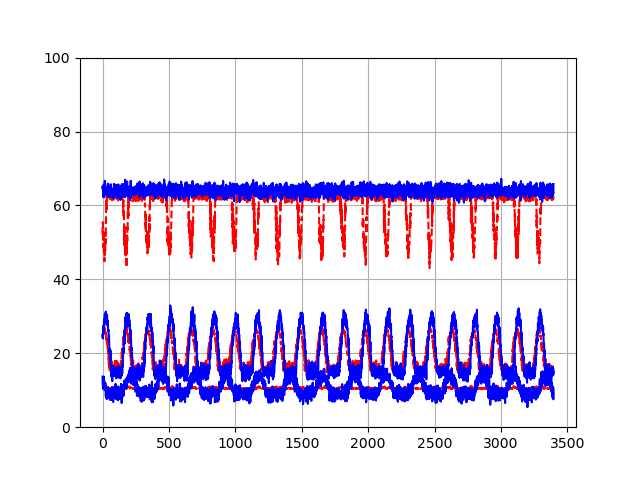

In [10]:
z = compare(train_data, v)

In [55]:
z = compare(test_data, v)

In [9]:
test(v, test_data, criterion, device)

====> Test set loss: 40.7919


1000


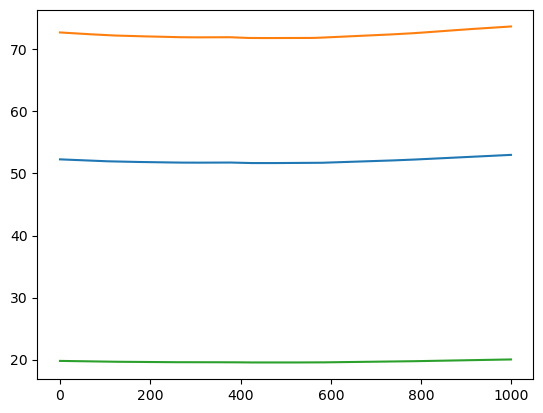

In [36]:
rec = []
for i in range(1000):
    z[16] = 0.01*i
    
    x_rec = v.decoder(z)

    rec.append(x_rec.detach().numpy())
print(len(rec))
plt.plot(rec)

In [37]:
z = np.arange(0.001,1, 0.01)
z

array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991])

In [40]:
# %matplotlib 
# import ipywidgets as widgets

# z = np.arange(16)
# @interact(z, np.arange(0.001,10, 0.01))
def experiment(z,z_num):
    rec = []
    for i in range(1000):
        z[z_num] = 0.01*i

        x_rec = v.decoder(z)

        rec.append(x_rec.detach().numpy())
    print(len(rec))
    plt.plot(rec)
    
# widgets.interact(experiment, z)

1000


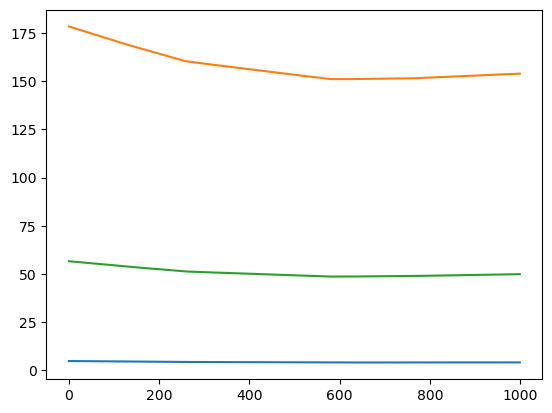

In [64]:
experiment(z,3)

In [ ]:
1) Pulse/ Rechteck
2) Trends (linear or not)
3) Periodicity
std. effects
5) coupling durch cov matrix
6) Noise
7) Effect of latent dim änderung, welche größe ist am besten  geeignet, soll latent_dim = n_channels sein? couploung durch hiarchie?
Modeling of interactions effects in die simulation hilft um die interpretation zu validieren, man kann die effecte aus der realen daten 
besser mathematisch verstehen
8) Short and long term effects durch die verschiedenen Convolutions weights"aktivierung von neuronen/ welche neuraonen sind mehr active in welche fälle"
idee is to know what layers capt long term effects and which layers capt short terms to be able to better interpret the data
9) also change the effects to be intern effects -> they happen on the level of mean and std rather than additif to the channels and let only be some random noise additif (y = x +epsilon)
all the rest (trends, seasonalities, pulses should happen on the level of mean and std)


Write and document all the steps I wanna do and make check list
try to make the data scales and dimention real (x axes represents tims -> days, hours, secs / are the seasonalities daily or weekly etc)

In [4]:
60/5

12.0

In [5]:
12*24

288

In [6]:
288*7

2016

In [7]:
2016*4

8064

In [8]:
60*24

1440

In [4]:
array = np.random.randint(10, size=(5,5))

In [5]:
array

array([[1, 8, 4, 1, 3],
       [6, 5, 3, 9, 6],
       [9, 1, 9, 4, 2],
       [6, 7, 8, 8, 9],
       [2, 0, 6, 7, 8]])

In [16]:
channels = [2,4]
start_idx = [1,2]
end_idx = [4,4]
[array[channels[i],start_idx[i]:end_idx[i]] for i in range(len(channels))]
# array[channels[,]start_idx]

[array([1, 9, 4]), array([6, 7])]

In [10]:
720/24

30.0

In [40]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact



def experiment(data, model):
    x = []
    z = []
    rec = []
    with torch.no_grad():
        for i, data in enumerate(data):
            x_rec, mu, logvar = model(data)
            Z = v.reparametrization_trick(mu, logvar)
            
            x.extend(data[:,:,0].detach().numpy())
            z.extend(Z[:].detach().numpy())
            rec.extend(x_rec[:].detach().numpy())
            
    x = np.array(x)
    z = np.array(z)
    rec = np.array(rec)                 

    # Create a figure and axis object
    fig, axs = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [1, 2]})   
    
    # Plot the initial data
    ax1 = axs[0]
    ax2 = axs[1]
    line1 = ax1.plot(x, "b")
    line2 = ax1.plot( rec, "r")
    line3 = ax2.plot( z, "g")
    
    
    sliders = []
    slider_axs = []
              
#     # Add a slider widget for variable 1
    for i in range(z.shape[1]):
        slider_axs.append( plt.axes([0.1, (0.00-0.05*i), 0.8, 0.03]) )
        sliders.append( Slider(slider_axs[i], r'$Z_{}$'.format(i), -10, 10, valinit=z[-1,i]) )   


    # Define a function to update the plot
    def update(val):
        
        for i in range(z.shape[1]):
            z[:,i] = sliders[i]. val            
        rec = v.decoder(z)        

        line2.set_ydata(rec)    
        line3.set_ydata(z)

        fig.canvas.draw_idle()

    # Connect the sliders to the update function
    for slider in sliders:
        slider.on_changed(update)

    # Show the plot
    plt.show()

In [41]:
experiment(test_data, v)

In [33]:
??go.layout.Slider